## Set up:

In [13]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import join
import pandas as pd
import re
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.colors as mcolors
from shapely.geometry import box
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
import massbalancemachine as mbm
from cmcrameri import cm

from scripts.geodata import *
from scripts.geodata_plots import *
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon
color_palette_glaciers = sns.color_palette(get_cmap_hex(cmap, 15))

colors = get_cmap_hex(cm.batlow, 2)
color_xgb = colors[0]
color_tim = '#c51b7d'

In [15]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
#rgi_df.set_index('rgi_id.v6', inplace=True)
rgi_df.head(2)

,short_name,full_name,sgi-id,rgi_id_v6_2016_shp,rgi_id.v6,rgi_id.v7,Issue
0,adler,Adler,B56-14,RGI60-11.B56-14,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
1,albigna,Albigna,C84-16,RGI60-11.C84-16,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [16]:
# Load the shapefile
shapefile_path = "../../../data/GLAMOS/topo/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)

# Order glaciers by size:
gl_area = {}
for glacierName in os.listdir('results/nc/sgi_corr/'):
    if glacierName == 'clariden':
        sgi_id = rgi_df[rgi_df.short_name ==
                        'claridenU']['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         'claridenU']['rgi_id_v6_2016_shp'].values[0]
    else:
        sgi_id = rgi_df[rgi_df.short_name ==
                        glacierName]['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         glacierName]['rgi_id_v6_2016_shp'].values[0]

    # 2016 shapefile of glacier
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]
    gl_area[glacierName] = gdf_mask_gl.Area.values[0]

# sort by area (smallest first)
glacier_list = sorted(gl_area, key=lambda x: gl_area[x], reverse=False)
glacier_list

['schwarzbach',
 'taelliboden',
 'joeri',
 'sanktanna',
 'corvatsch',
 'sexrouge',
 'murtel',
 'plattalva',
 'tortin',
 'basodino',
 'limmern',
 'adler',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'oberaar',
 'gries',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'morteratsch',
 'corbassiere',
 'gorner',
 'aletsch']

## Stake coverage:

In [17]:
vois_climate = [
    't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES

year = 2018
month = 'jul'

for glacierName in glacier_list:
    df_grid_monthly = pd.read_csv(path_glacier_grid_sgi +
                                    f'{glacierName}_grid_{year}.csv')

    # Correct climate grids:
    df_grid_monthly = correct_vars_grid(df_grid_monthly)

    # Rename aspect and slope to sgi
    df_grid_monthly.rename(columns={
        'aspect': 'aspect_sgi',
        'slope': 'slope_sgi'
    },
                            inplace=True)
    df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
    df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
    df_grid_monthly = df_grid_monthly[all_columns]

    df_grid_month = df_grid_monthly[df_grid_monthly.MONTHS == month]

    # stakes
    df_stakes = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')
    df_stakes = df_stakes[(df_stakes['GLACIER'] == glacierName)]

    # coordinates
    geometry = [
        Point(xy) for xy in zip(df_stakes.POINT_LON, df_stakes.POINT_LAT)
    ]
    gdf_stakes = gpd.GeoDataFrame(df_stakes,
                                    crs='EPSG:4326',
                                    geometry=geometry)

    sgi_grid = xr.open_dataset(path_SGI_topo+f'xr_masked_grids/{glacierName}.nc')

    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    sgi_grid.glacier_mask.plot(cmap = 'binary', ax = ax, alpha = 0.5)
    sns.scatterplot(data=df_grid_month,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue='ELEVATION_DIFFERENCE',
                    ax=ax,
                    s=5,
                    palette='twilight_shifted')
    # plot coordinates
    gdf_stakes.plot(ax=ax, color='blue', markersize=3)
    ax.legend().remove()
    ax.set_title(f'{glacierName}')
    
    # save figure
    plt.savefig(f'figures/stake_coverage/{glacierName}.png', dpi=300)
    
    # Clear the plot to free memory
    plt.close()

## Glacier wide MB:

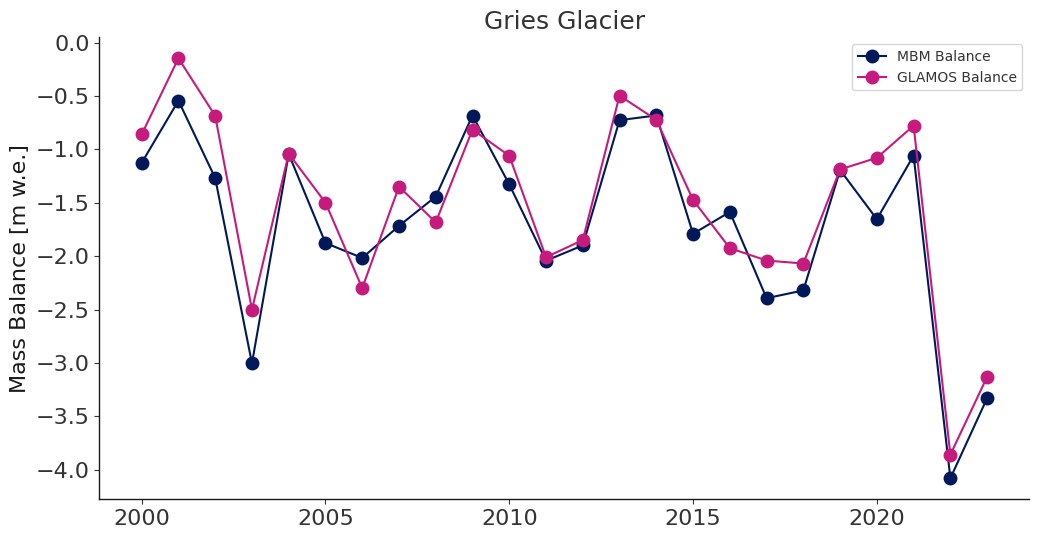

In [6]:
# Example:
glacierName = 'gries'
df_target = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                        f'{glacierName}_fix.csv')
df_target = transformDates(df_target)

# Remove obvious duplicates:
df_target = df_target.drop_duplicates()
df_target['YEAR'] = df_target['date1'].apply(lambda x: pd.to_datetime(x).year)
df_target['GLAMOS Balance'] = df_target['Annual Balance'] / (1000)
df_target = df_target[['YEAR', 'GLAMOS Balance']].set_index('YEAR')

# Load the model data
path_results = f'results/nc/sgi_corr/{glacierName}/'
pred_gl = []
for year in range(2000, 2024):
    pred_gl.append(
        xr.open_dataset(
            path_results +
            f'{glacierName}_{year}_annual.nc').pred_masked.mean().item())

glwide_MB = pd.DataFrame(pred_gl, columns=['MBM Balance'])
glwide_MB.index = range(2000, 2024)
# add the target data
glwide_MB = glwide_MB.join(df_target)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
glwide_MB.plot(ax=ax, marker='o', color=[color_xgb, color_tim])
plt.title(f'{glacierName.capitalize()} Glacier')
plt.ylabel('Mass Balance [m w.e.]')
plt.grid()

In [12]:
# Save for all glaciers
for glacierName in glacier_list:
    # if file exists:
    if not os.path.exists(path_SMB_GLAMOS_csv + 'fix/' +
                          f'{glacierName}_fix.csv'):
        continue
    df_target = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                            f'{glacierName}_fix.csv')
    df_target = transformDates(df_target)

    # Remove obvious duplicates:
    df_target = df_target.drop_duplicates()
    df_target['YEAR'] = df_target['date1'].apply(
        lambda x: pd.to_datetime(x).year)
    df_target['GLAMOS Balance'] = df_target['Annual Balance'] / (1000)
    df_target = df_target[['YEAR', 'GLAMOS Balance']].set_index('YEAR')

    # Load the model data
    path_results = f'results/nc/sgi_corr/{glacierName}/'
    pred_gl = []
    for year in range(2000, 2024):
        pred_gl.append(
            xr.open_dataset(
                path_results +
                f'{glacierName}_{year}_annual.nc').pred_masked.mean().item())

    glwide_MB = pd.DataFrame(pred_gl, columns=['MBM Balance'])
    glwide_MB.index = range(2000, 2024)
    # add the target data
    glwide_MB = glwide_MB.join(df_target)

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 6))
    glwide_MB.plot(ax=ax, marker='o', color=[color_xgb, color_tim])
    plt.title(f'{glacierName.capitalize()} Glacier')
    plt.ylabel('Mass Balance [m w.e.]')
    plt.grid()

    # Save the figure
    path_fig = 'figures/glacierwide/' + f'{glacierName}.png'
    plt.savefig(path_fig, dpi=300)
    
    # Clear the plot to free memory
    plt.close()

## Distributed GLAMOS:

In [18]:
def apply_gaussian_filter(ds, variable_name = 'pred_masked', sigma: float = 1):
    # Get the DataArray for the specified variable
    data_array = ds[variable_name]

    # Step 1: Create a mask of valid data (non-NaN values)
    mask = ~np.isnan(data_array)

    # Step 2: Replace NaNs with zero (or a suitable neutral value)
    filled_data = data_array.fillna(0)

    # Step 3: Apply Gaussian filter to the filled data
    smoothed_data = gaussian_filter(filled_data, sigma=sigma)

    # Step 4: Restore NaNs to their original locations
    smoothed_data = xr.DataArray(
        smoothed_data,
        dims=data_array.dims,
        coords=data_array.coords,
        attrs=data_array.attrs).where(mask)  # Apply the mask to restore NaNs
    
    ds[variable_name] = smoothed_data
    
    return ds


-3.4711645484278426 0.16834116


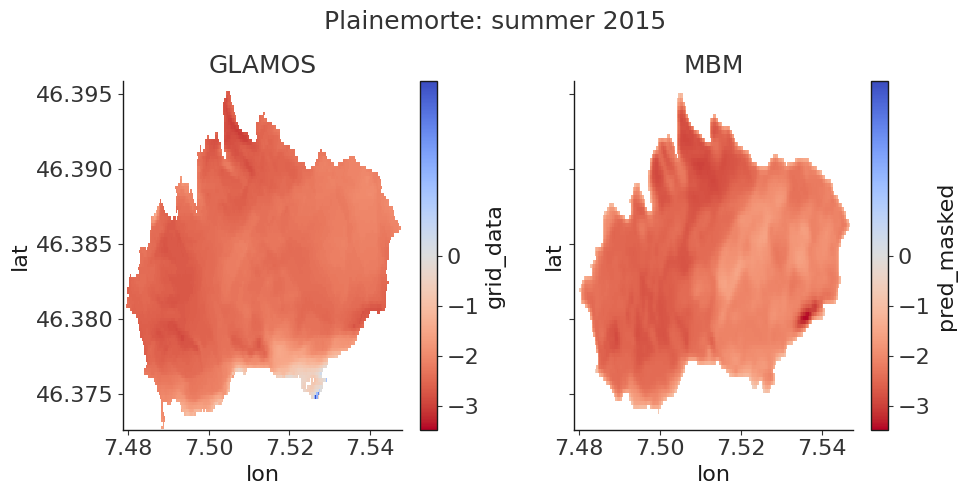

In [43]:
path_distributed_glamos = '../../../data/GLAMOS/distribution-grids/lv95/'
glacierName = 'plainemorte'
year = 2015

fileName = f'{year}_ann_fix_lv95.grid'
metadata, grid_data = load_grid_file(path_distributed_glamos + glacierName +
                                     '/' + fileName)
# Convert to xarray
ds = convert_to_xarray_geodata(grid_data, metadata)
# Transform the coordinates to WGS84
ds_wgs84 = transform_xarray_coords_lv95_to_wgs84(ds)

ds_mbm = xr.open_dataset(
    f'results/nc/sgi_corr/{glacierName}/{glacierName}_{year}_annual.nc')
ds_mbm = apply_gaussian_filter(ds_mbm)

vmin = min(ds_wgs84.min().item(), ds_mbm.pred_masked.min().item())
vmax = max(ds_wgs84.max().item(), ds_mbm.pred_masked.max().item())
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

print(vmin, vmax)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ds_wgs84.plot(
    ax=ax[0],
    cmap='coolwarm_r',
    norm = norm
)
ax[0].set_title('GLAMOS')

# Plot MBM predictions:
ds_mbm.pred_masked.plot(
    ax=ax[1],
    cmap='coolwarm_r',
    norm = norm
    
)
ax[1].set_title('MBM')
plt.suptitle(f'{glacierName.capitalize()}: summer {year}')
plt.tight_layout()

## Geodetic MB:

In [44]:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
rgi_df.head(2)

,full_name,sgi-id,rgi_id_v6_2016_shp,rgi_id.v6,rgi_id.v7,Issue
short_name,,,,,,
adler,Adler,B56-14,RGI60-11.B56-14,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
albigna,Albigna,C84-16,RGI60-11.C84-16,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [45]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
processed_gl = os.listdir('results/nc/sgi_corr/')

# get rgi of those glaciers:
rgi_gl = []
for gl in processed_gl:
    if gl == 'clariden':
        rgi_gl.append(rgi_df.loc['claridenU']['rgi_id_v6_2016_shp'])
    else:
        rgi_gl.append(rgi_df.loc[gl]['rgi_id_v6_2016_shp'])

sgi_gl = [
    rgi_df[rgi_df['rgi_id_v6_2016_shp'] == rgi]['sgi-id'].values[0]
    for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
# replace claridenL by clariden
glacierNames = [
    glacierName.replace('claridenL', 'clariden')
    for glacierName in glacierNames
]
geodeticMB['glacierName'] = glacierNames

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)


### Compare to geodetic MB:

#### Example:

Text(0.5, 1.0, 'Aletsch Glacier')

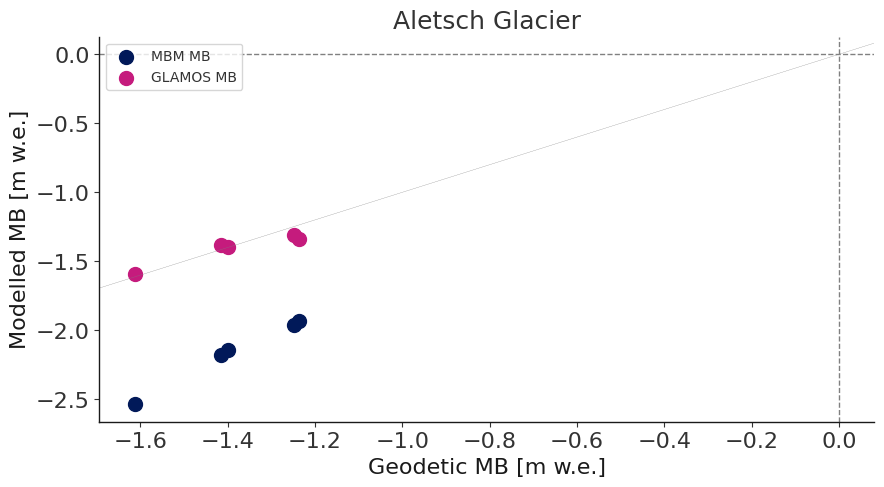

In [46]:
glacierName = 'aletsch'

GLAMOS_glwmb = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                           f'{glacierName}_fix.csv')
GLAMOS_glwmb = transformDates(GLAMOS_glwmb)

# Remove obvious duplicates:
GLAMOS_glwmb = GLAMOS_glwmb.drop_duplicates()
GLAMOS_glwmb['YEAR'] = GLAMOS_glwmb['date1'].apply(
    lambda x: pd.to_datetime(x).year)
GLAMOS_glwmb['GLAMOS Balance'] = GLAMOS_glwmb['Annual Balance'] / (1000)
GLAMOS_glwmb = GLAMOS_glwmb[['YEAR', 'GLAMOS Balance']].set_index('YEAR')

# get all periods
periods = periods_per_glacier[glacierName]
geoMBs = geoMB_per_glacier[glacierName]

# Open glacier-wide MB nc files for all years of the period
path = f'results/nc/sgi_corr/{glacierName}/'

mbm_mb_mean, glamos_mb_mean, geodetic_mb, target_period = [], [], [], []
for period in periods:
    mbm_mb, glamos_mb = [], []
    for year in range(period[0], period[1] + 1):
        # Get the glacier-wide MB
        ds = xr.open_dataset(path + f'{glacierName}_{year}_annual.nc')
        # Glacier wide MB is mean of all grid cells
        mbm_mb.append(ds['pred_masked'].mean().values)

        glamos_mb.append(GLAMOS_glwmb['GLAMOS Balance'].loc[year])

    mbm_mb_mean.append(np.mean(mbm_mb))
    glamos_mb_mean.append(np.mean(glamos_mb))
    geodetic_mb.append(geoMBs[periods.index(period)])
    target_period.append(period)

# Plot the geodetic MB and the modelled MB
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(geodetic_mb, mbm_mb_mean, color=color_xgb, label='MBM MB')
ax.scatter(geodetic_mb, glamos_mb_mean, color=color_tim, label='GLAMOS MB')
ax.legend(loc='upper left')
# add identity line
# diagonal line
pt = (0, 0)
ax.axline(pt, slope=1, color="grey", linestyle="-", linewidth=0.2)
ax.axvline(0, color="grey", linestyle="--", linewidth=1)
ax.axhline(0, color="grey", linestyle="--", linewidth=1)
ax.grid()
# legend
ax.set_xlabel('Geodetic MB [m w.e.]')
ax.set_ylabel('Modelled MB [m w.e.]')
# add title
ax.set_title(f'{glacierName.capitalize()} Glacier')

#### All glaciers:

In [47]:
# Save for all glaciers
path_figures = 'figures/geodetic/'
emptyfolder(path_figures)

for glacierName in glacier_list:
    # if file exists:
    if not os.path.exists(path_SMB_GLAMOS_csv + 'fix/' +
                          f'{glacierName}_fix.csv'):
        continue
    GLAMOS_glwmb = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                               f'{glacierName}_fix.csv')
    GLAMOS_glwmb = transformDates(GLAMOS_glwmb)

    # Remove obvious duplicates:
    GLAMOS_glwmb = GLAMOS_glwmb.drop_duplicates()
    GLAMOS_glwmb['YEAR'] = GLAMOS_glwmb['date1'].apply(
        lambda x: pd.to_datetime(x).year)
    GLAMOS_glwmb['GLAMOS Balance'] = GLAMOS_glwmb['Annual Balance'] / (1000)
    GLAMOS_glwmb = GLAMOS_glwmb[['YEAR', 'GLAMOS Balance']].set_index('YEAR')

    # get all periods
    periods = periods_per_glacier[glacierName]
    geoMBs = geoMB_per_glacier[glacierName]

    # Open glacier-wide MB nc files for all years of the period
    path = f'results/nc/sgi_corr/{glacierName}/'

    mbm_mb_mean, glamos_mb_mean, geodetic_mb, target_period = [], [], [], []
    for period in periods:
        mbm_mb, glamos_mb = [], []
        for year in range(period[0], period[1] + 1):
            # Get the glacier-wide MB
            ds = xr.open_dataset(path + f'{glacierName}_{year}_annual.nc')
            # Glacier wide MB is mean of all grid cells
            mbm_mb.append(ds['pred_masked'].mean().values)
            if year in GLAMOS_glwmb.index:
                glamos_mb.append(GLAMOS_glwmb['GLAMOS Balance'].loc[year])

        mbm_mb_mean.append(np.mean(mbm_mb))
        glamos_mb_mean.append(np.mean(glamos_mb))
        geodetic_mb.append(geoMBs[periods.index(period)])
        target_period.append(period)

    # only if more than one measurement
    if len(geodetic_mb) > 1:
        # Plot the geodetic MB and the modelled MB
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(geodetic_mb, mbm_mb_mean, color=color_xgb, label='MBM MB')
        ax.scatter(geodetic_mb,
                   glamos_mb_mean,
                   color=color_tim,
                   label='GLAMOS MB')
        ax.legend(loc='upper left')
        # add identity line
        # diagonal line
        pt = (0, 0)
        ax.axline(pt, slope=1, color="grey", linestyle="-", linewidth=0.2)
        ax.axvline(0, color="grey", linestyle="--", linewidth=1)
        ax.axhline(0, color="grey", linestyle="--", linewidth=1)
        ax.grid()
        # legend
        ax.set_xlabel('Geodetic MB [m w.e.]')
        ax.set_ylabel('Modelled MB [m w.e.]')
        # add title
        ax.set_title(f'{glacierName.capitalize()} Glacier')

        # save the figure
        path_fig = path_figures + f'{glacierName}.png'
        fig.savefig(path_fig)
        
        plt.close()

#### One plot:

In [48]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'joeri', 'corvatsch', 'tsanfleuron'
]

mbm_mb_mean, glamos_mb_mean, geodetic_mb, gl, period_len, gl_type, area = [], [], [], [], [], [], []

for glacierName in tqdm(os.listdir('results/nc/sgi_corr/')):
    # if file exists:
    if not os.path.exists(path_SMB_GLAMOS_csv + 'fix/' +
                          f'{glacierName}_fix.csv'):
        continue
    GLAMOS_glwmb = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                               f'{glacierName}_fix.csv')
    GLAMOS_glwmb = transformDates(GLAMOS_glwmb)

    # Remove obvious duplicates:
    GLAMOS_glwmb = GLAMOS_glwmb.drop_duplicates()
    GLAMOS_glwmb['YEAR'] = GLAMOS_glwmb['date1'].apply(
        lambda x: pd.to_datetime(x).year)
    GLAMOS_glwmb['GLAMOS Balance'] = GLAMOS_glwmb['Annual Balance'] / (1000)
    GLAMOS_glwmb = GLAMOS_glwmb[['YEAR', 'GLAMOS Balance']].set_index('YEAR')

    # get all periods
    periods = periods_per_glacier[glacierName]
    geoMBs = geoMB_per_glacier[glacierName]

    # Open glacier-wide MB nc files for all years of the period
    path = f'results/nc/sgi_corr/{glacierName}/'

    for period in periods:
        mbm_mb, glamos_mb = [], []
        for year in range(period[0], period[1] + 1):
            # Get the glacier-wide MB
            ds = xr.open_dataset(path + f'{glacierName}_{year}_annual.nc')
            # Glacier wide MB is mean of all grid cells
            mbm_mb.append(ds['pred_masked'].mean().values)
            if year in GLAMOS_glwmb.index:
                glamos_mb.append(GLAMOS_glwmb['GLAMOS Balance'].loc[year])

        mbm_mb_mean.append(np.mean(mbm_mb))
        glamos_mb_mean.append(np.mean(glamos_mb))
        geodetic_mb.append(geoMBs[periods.index(period)])
        gl.append(glacierName)
        gl_type.append(glacierName in test_glaciers)
        period_len.append(period[1] - period[0])
        area.append(gl_area[glacierName])

df_all = pd.DataFrame({
    'MBM MB': mbm_mb_mean,
    'GLAMOS MB': glamos_mb_mean,
    'Geodetic MB': geodetic_mb,
    'GLACIER': gl,
    'Period Length': period_len,
    'Test glacier': gl_type,
    'Area': area  # in km^2
})
df_all.sort_values(by='Area', inplace=True)

df_all.head(2)

  0%|          | 0/31 [00:00<?, ?it/s]

,MBM MB,GLAMOS MB,Geodetic MB,GLACIER,Period Length,Test glacier,Area
204,-1.680844,-0.932667,-0.694,schwarzbach,5,False,0.049129
203,-1.680844,-0.932667,-0.694,schwarzbach,5,False,0.049129


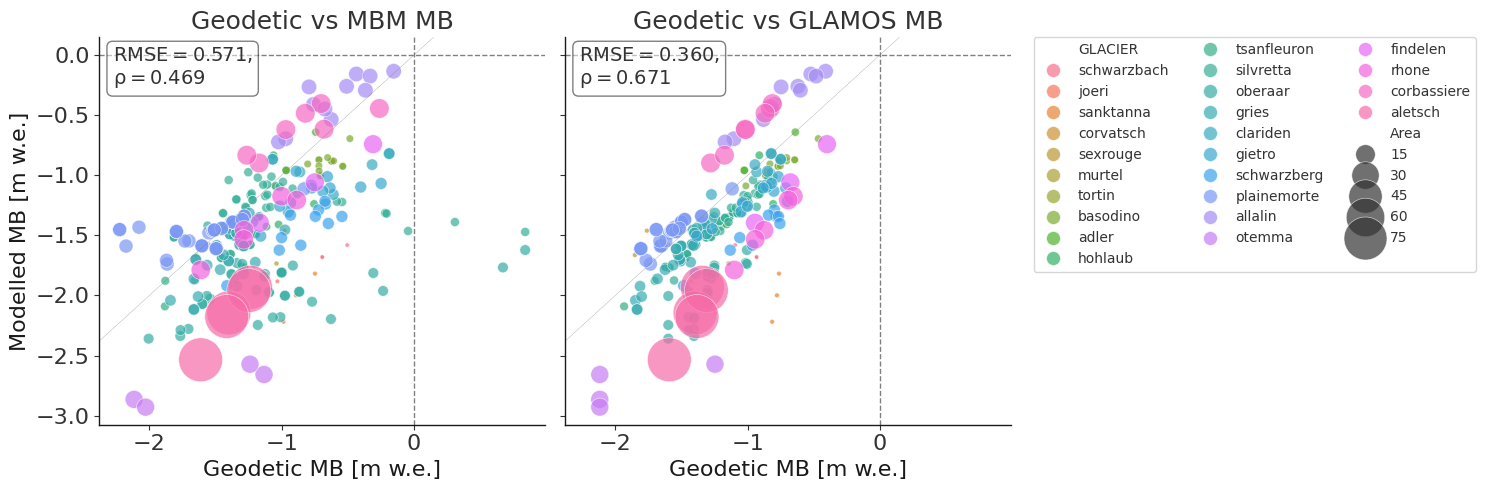

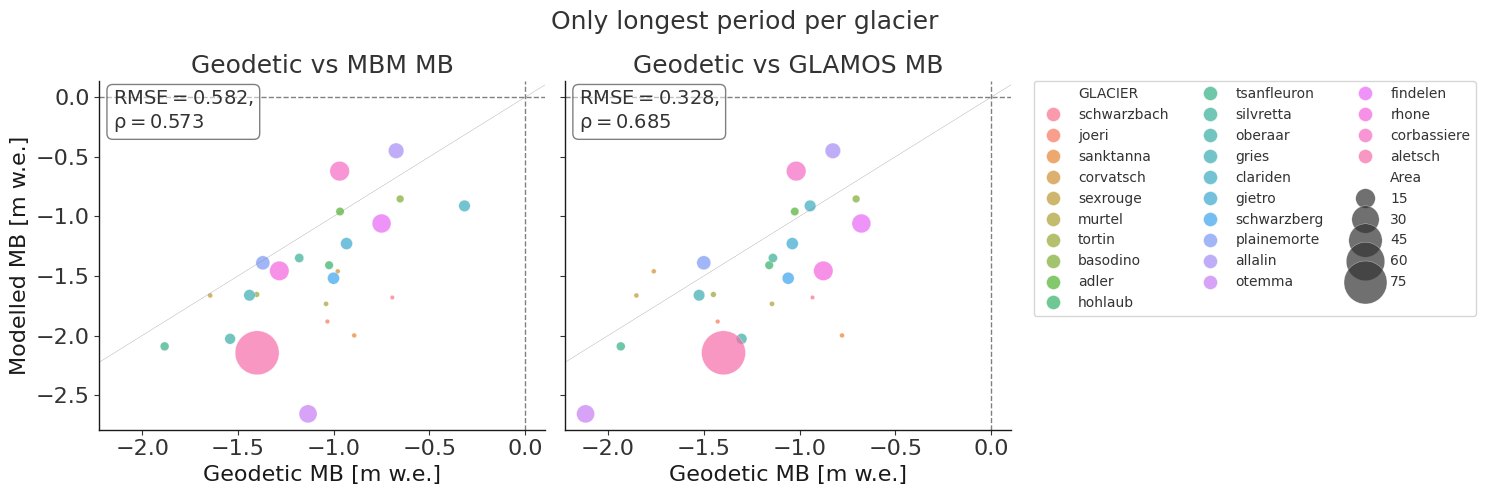

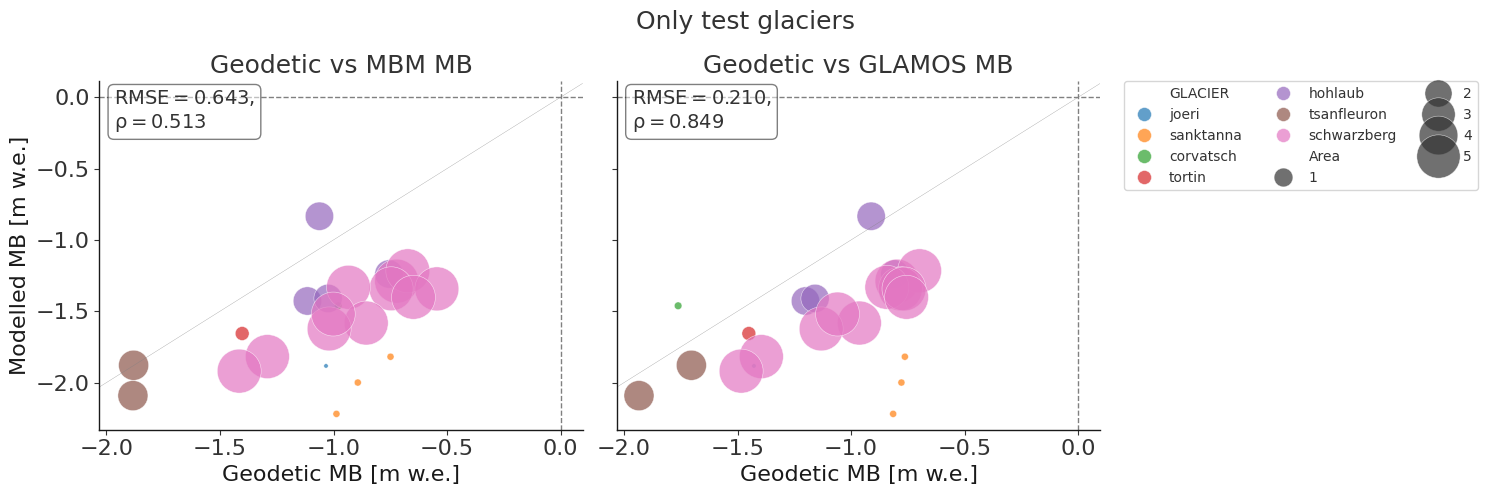

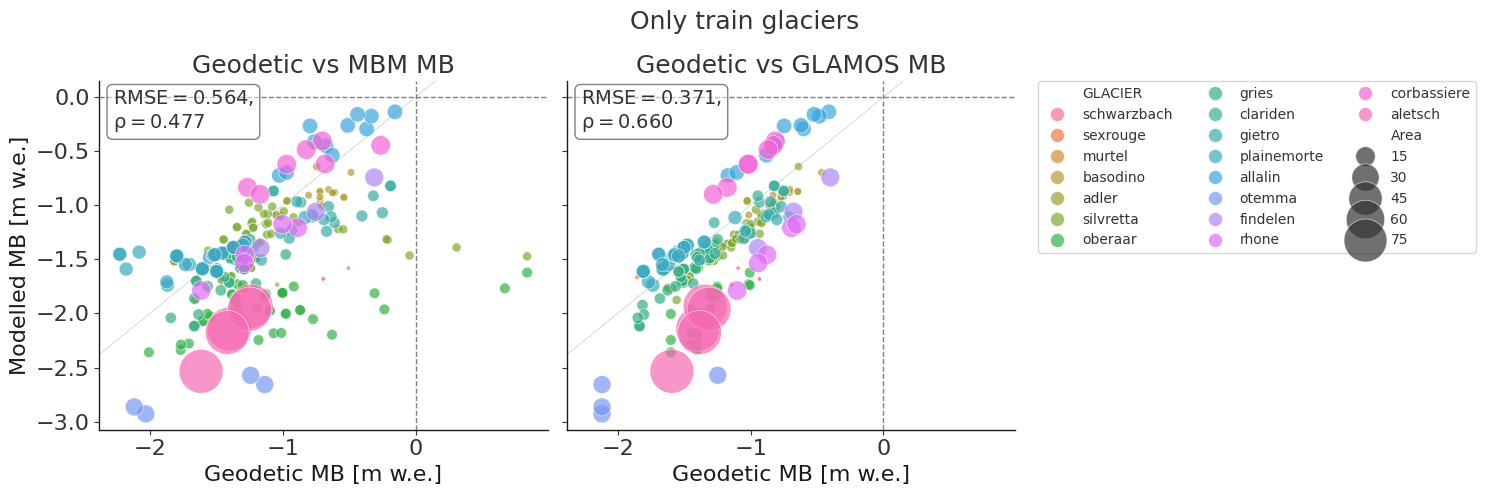

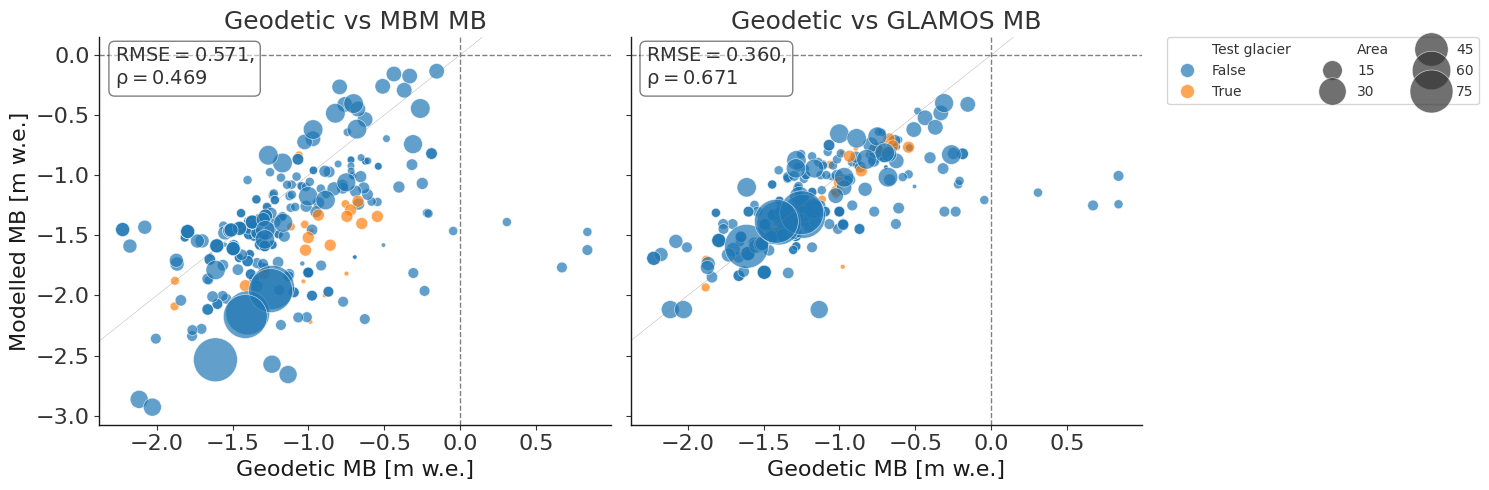

In [52]:
# All glaciers
scatter_geodeticMB(df_all)
plt.tight_layout()

# Only longest period per glacier
df_longest = df_all.loc[df_all.groupby('GLACIER')['Period Length'].idxmax()]
df_longest.sort_values(by='Area', inplace=True)
scatter_geodeticMB(df_longest)
plt.suptitle('Only longest period per glacier')
plt.tight_layout()

# Only test glaciers
df_test = df_all[df_all['Test glacier']]
df_test.sort_values(by='Area', inplace=True)
scatter_geodeticMB(df_test)
plt.suptitle('Only test glaciers')
plt.tight_layout()

# Only non-test glaciers
df_non_test = df_all[~df_all['Test glacier']]
df_non_test.sort_values(by='Area', inplace=True)
scatter_geodeticMB(df_non_test)
plt.suptitle('Only train glaciers')
plt.tight_layout()

# Plot scatterplot but size is  proportional to glacier area
scatter_geodeticMB(df_all, size=True)
plt.tight_layout()

## S2 Sentinel data:

### Get S2 rasters:
Get the names of all satellite nc files and classifiy them per month and hydrological year.

In [53]:
# Sentinel-2
path_S2 = '../../../data/Sentinel/'
src_crs = 'EPSG:4326'  # Original CRS (lat/lon) wgs84

# Organize the rasters by hydrological year
satellite_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

rasters_S2 = organize_rasters_by_hydro_year(path_S2, satellite_years)

# Print the organized rasters
for hydro_year, months in rasters_S2.items():
    print(f"-----------------\nHydrological Year: {hydro_year}")
    for month, files in months.items():
        print(f"  {month}: {files}")

-----------------
Hydrological Year: 2015
  jul: ['GLF_S2A_MSIL1C_20150806T102016_N0204_R065_T32TMS_20150806T102012_10m_r.tif']
  aug: ['GLF_S2A_MSIL1C_20150826T102026_N0204_R065_T32TMS_20150826T102655_10m_r.tif']
-----------------
Hydrological Year: 2017
  sep: ['GLF_S2A_MSIL1C_20160929T102022_N0204_R065_T32TMS_20160929T102344_10m_r.tif']
  oct: ['GLF_S2A_MSIL1C_20161029T102132_N0204_R065_T32TMS_20161029T102445_10m_r.tif']
  jun: ['GLF_S2A_MSIL1C_20170626T102021_N0205_R065_T32TMS_20170626T102321_10m_r.tif', 'GLF_S2A_MSIL1C_20170706T102021_N0205_R065_T32TMS_20170706T102301_10m_r.tif']
  jul: ['GLF_S2A_MSIL1C_20170716T102021_N0205_R065_T32TMS_20170716T102324_10m_r.tif', 'GLF_S2A_MSIL1C_20170805T102031_N0205_R065_T32TMS_20170805T102535_10m_r.tif']
  may: ['GLF_S2A_MSIL1C_20170527T102031_N0205_R065_T32TMS_20170527T102301_10m_r.tif', 'GLF_S2A_MSIL1C_20170517T102031_N0205_R065_T32TMS_20170517T102352_10m_r.tif']
  aug: ['GLF_S2B_MSIL1C_20170820T102019_N0205_R065_T32TMS_20170820T102346_10m_r.

### Create gdf for S2 rasters:
Create panadas geodataframe for each satellite raster.

In [54]:
satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'claridenL', 'claridenU',
    'findelen', 'gries', 'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone',
    'sanktanna', 'schwarzbach', 'schwarzberg'
]

processed_gl = os.listdir('results/nc/sgi_corr/')

# list of gl in processed_gl that are also in satellite_glaciers
satellite_glaciers = [gl for gl in processed_gl if gl in satellite_glaciers]
satellite_glaciers

['plattalva',
 'gries',
 'adler',
 'schwarzberg',
 'rhone',
 'oberaar',
 'findelen',
 'hohlaub',
 'allalin',
 'basodino',
 'limmern',
 'schwarzbach',
 'sanktanna',
 'aletsch']

## SGI rasters:

### S2 rasters over glaciers:

In [55]:
RUN = False
if RUN:
    # emptyfolder(os.path.join(path_S2, 'perglacier/'))
    # For each year and month where there is S2 data
    for hydro_year, months in tqdm(rasters_S2.items(),
                                   position=0,
                                   desc='Hydrological Years'):
        for month, files in tqdm(months.items(),
                                 position=1,
                                 leave=False,
                                 desc='Months'):

            # More than one if S2 A and B flew in the same month
            for raster_name in files:
                # Create raster for that year & month:
                file_date = datetime.strptime(
                    raster_name.split('_')[3][:8],
                    "%Y%m%d")  # Extract the 8-digit date (YYYYMMDD)

                # Path to the raster for that year & month:
                raster_path = os.path.join(path_S2, file_date.strftime('%Y'),
                                           raster_name)

                # Creates a geodataframe from the .tif raster
                # This is the longest part of the code
                geo_data_S2 = mbm.GeoData(pd.DataFrame)
                gdf_S2 = geo_data_S2.raster_to_gpd(raster_path)
                geo_data_S2.set_gdf(gdf_S2)

                # For each glacier, clip the S2 raster to the glacier extent
                for glacierName in tqdm(satellite_glaciers,
                                        position=2,
                                        leave=False,
                                        desc='Glaciers'):

                    # Load MB predictions for that year and month
                    path_nc_wgs84 = f"results/nc/sgi_corr/{glacierName}/"
                    filename_nc = f"{glacierName}_{hydro_year}_{month_abbr_hydr_full[month]}.nc"

                    # check if file exists:
                    if not os.path.exists(
                            os.path.join(path_nc_wgs84, filename_nc)):
                        continue

                    # Open xarray dataset and set to class:
                    geoData_gl = mbm.GeoData(pd.DataFrame)
                    geoData_gl.set_ds_latlon(filename_nc, path_nc_wgs84)

                    # Clip the S2 dataframe to the glacier extent
                    # and resample it to the glacier resolution
                    gdf_raster_res = mbm.GeoData.resample_satellite_to_glacier(
                        geoData_gl.gdf, gdf_S2)

                    # In case the glacier is outside of the bounds of the raster
                    if gdf_raster_res is 0:
                        continue
                    # In case the raster is empty where the glacier is
                    elif gdf_raster_res is 1:
                        continue
                    else:
                        pass

                    # Check the percentage of cloud cover
                    cloud_cover_glacier = gdf_raster_res.classes[
                        gdf_raster_res.classes ==
                        5].count() / gdf_raster_res.classes.count()

                    # If the cloud cover is too high, skip the glacier
                    if cloud_cover_glacier > 0.5:
                        continue

                    # Save the glacier raster:
                    S2_gl_name = '{}_{}.geojson'.format(
                        glacierName, file_date.strftime('%Y_%m_%d'))
                    S2_gl_path = os.path.join(path_S2, 'perglacier',
                                              S2_gl_name)
                    gdf_raster_res.to_file(S2_gl_path, driver="GeoJSON")

### Example of one glacier:

In [88]:
# get glacier coordinates:
glacierName = 'rhone'
year = 2017
month = '08'
# monthNb = month_abbr_hydr_full[month]

rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (glacierName in f) and (str(year) in f)
]
rasters_gl.sort()
rasters_gl

['rhone_2017_05_17.geojson',
 'rhone_2017_05_27.geojson',
 'rhone_2017_06_26.geojson',
 'rhone_2017_07_06.geojson',
 'rhone_2017_08_05.geojson',
 'rhone_2017_08_20.geojson',
 'rhone_2017_10_14.geojson']

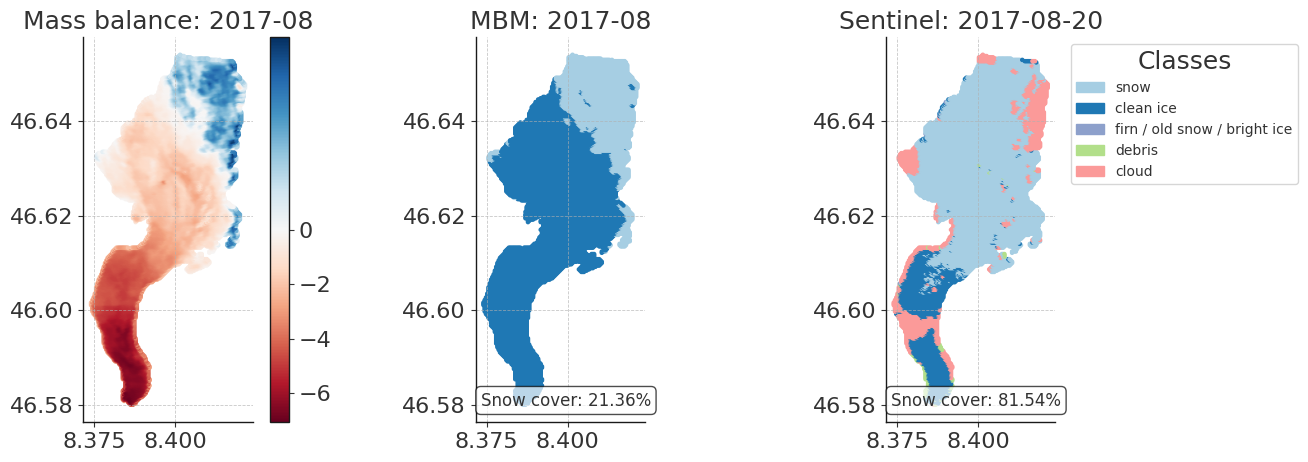

<Figure size 640x480 with 0 Axes>

In [86]:
# Read the glacier shapefile
# filename_nc = f"{glacierName}_{year}_{monthNb}.nc"
filename_nc = f"{glacierName}_{year}_annual.nc"

# Open xarray dataset and set to class:
path_nc_wgs84 = f"results/nc/sgi_corr/{glacierName}/"
geoData_gl = mbm.GeoData(pd.DataFrame)
geoData_gl.set_ds_latlon(filename_nc, path_nc_wgs84)
geoData_gl.classify_snow_cover(tol=0.1)

# Read satellite raster
filenameS2 = 'rhone_2017_08_20.geojson'
gdf_S2_res = gpd.read_file(os.path.join(path_S2, 'perglacier', filenameS2))

match = re.search(r'(\d{4}_\d{2}_\d{2})', filenameS2)
date_str = match.group(1)
file_date = datetime.strptime(date_str, "%Y_%m_%d")
gl_date = str(year) + '-' + month

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plotClasses(geoData_gl.gdf,
            gdf_S2_res,
            axs,
            gl_date,
            file_date,
            band_size=50,
            percentage_threshold=50)
plt.tight_layout()

#### Input:

In [ ]:
vois_climate = [
    't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES

df_grid_monthly = pd.read_csv(path_glacier_grid_sgi +
                              f'{glacierName}_grid_{year}.csv')

# Correct climate grids:
# Take the biggest grid cell value for each month
for voi in [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10',
        'ALTITUDE_CLIMATE'
]:
    df_grid_monthly = correct_for_biggest_grid(
        df_grid_monthly, group_columns=["YEAR", "MONTHS"], value_column=voi)

# New elevation difference:
df_grid_monthly['ELEVATION_DIFFERENCE'] = df_grid_monthly[
    "POINT_ELEVATION"] - df_grid_monthly["ALTITUDE_CLIMATE"]

# apply T & P correction
# Apply temperature gradient correction
temp_grad = -6.5 / 1000
dpdz = 1.5 / 10000
c_prec = 1.434,
t_off = 0.617

# Apply temperature correction factor
df_grid_monthly['t2m_corr'] = df_grid_monthly['t2m'] + (
    df_grid_monthly['ELEVATION_DIFFERENCE'] * temp_grad)
df_grid_monthly['t2m_corr'] += t_off

# Apply elevation correction factor
df_grid_monthly['tp_corr'] = df_grid_monthly['tp'] * c_prec
df_grid_monthly['tp_corr'] += df_grid_monthly['tp_corr'] * (
    df_grid_monthly['ELEVATION_DIFFERENCE'] * dpdz)

# Rename aspect and slope to sgi
df_grid_monthly.rename(columns={
    'aspect': 'aspect_sgi',
    'slope': 'slope_sgi'
},
                       inplace=True)
df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
df_grid_monthly = df_grid_monthly[all_columns]

df_grid_month = df_grid_monthly[df_grid_monthly.MONTHS == month]

In [ ]:
# Plot input features
# Plot climate features
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, voi in enumerate(vois_climate):
    sns.scatterplot(data=df_grid_month,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=voi,
                    ax=axs[i // 3, i % 3],
                    s=2)
    axs[i // 3, i % 3].set_title(voi)
    axs[i // 3, i % 3].set_ylabel('Lat')
    axs[i // 3, i % 3].set_xlabel('Lon')
    axs[i // 3, i % 3].legend().remove()
    axs[i // 3, i % 3].grid(False)
plt.tight_layout()

In [ ]:
# Plot input features
# Plot topographical features
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for i, voi in enumerate(['pcsr'] + list(vois_topographical) +
                        ['ELEVATION_DIFFERENCE']):
    sns.scatterplot(data=df_grid_month,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=voi,
                    ax=axs[i // 4, i % 4],
                    s=2,
                    palette='twilight_shifted')
    axs[i // 4, i % 4].set_title(voi)
    axs[i // 4, i % 4].set_ylabel('Lat')
    axs[i // 4, i % 4].set_xlabel('Lon')
    axs[i // 4, i % 4].legend().remove()
plt.tight_layout()

## Old RGI rasters:

In [ ]:
# RUN = False
# if RUN:
#     emptyfolder(os.path.join(path_S2, 'perglacier/'))
#     # For each year and month where there is S2 data
#     for hydro_year, months in tqdm(rasters_S2.items(),
#                                    position=0,
#                                    desc='Hydrological Years'):
#         for month, files in tqdm(months.items(),
#                                  position=1,
#                                  leave=False,
#                                  desc='Months'):

#             # More than one if S2 A and B flew in the same month
#             for raster_name in files:

#                 # Create raster for that year & month:
#                 file_date = datetime.strptime(
#                     raster_name.split('_')[3][:8],
#                     "%Y%m%d")  # Extract the 8-digit date (YYYYMMDD)

#                 # Path to the raster for that year & month:
#                 raster_path = os.path.join(path_S2, file_date.strftime('%Y'),
#                                            raster_name)

#                 # Creates a geodataframe from the .tif raster
#                 # This is the longest part of the code
#                 geoData_raster = mbm.GeoData(pd.DataFrame)
#                 gdf_S2 = geoData_raster.raster_to_gpd(raster_path)
#                 geoData_raster.set_gdf(gdf_S2)

#                 # For each glacier, clip the S2 raster to the glacier extent
#                 for glacierName in tqdm(satellite_glaciers,
#                                         position=2,
#                                         leave=False,
#                                         desc='Glaciers'):

#                     # Load MB predictions for that year and month
#                     path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
#                     filename_nc = f"{glacierName}_{hydro_year}_{month_abbr_hydr_full_hydr[month]}.nc"

#                     # Open xarray dataset and set to class:
#                     geoData_gl = mbm.GeoData(pd.DataFrame)
#                     geoData_gl.set_ds_latlon(filename_nc, path_nc_wgs84)

#                     # Convert xr in lat lon to GeoPandas
#                     geoData_gl.xr_to_gpd()

#                     # Clip the S2 dataframe to the glacier extent
#                     # and resample it to the glacier resolution
#                     gdf_raster_res = mbm.GeoData.resample_satellite_to_glacier(
#                         geoData_gl.gdf, gdf_S2)

#                     # In case the glacier is outside of the bounds of the raster
#                     if gdf_raster_res is 0:
#                         continue
#                     # In case the raster is empty where the glacier is
#                     elif gdf_raster_res is 1:
#                         continue
#                     else:
#                         pass

#                     # Check the percentage of cloud cover
#                     cloud_cover_glacier = gdf_raster_res.classes[
#                         gdf_raster_res.classes ==
#                         5].count() / gdf_raster_res.classes.count()

#                     # If the cloud cover is too high, skip the glacier
#                     if cloud_cover_glacier > 0.5:
#                         continue

#                     # Save the glacier raster:
#                     S2_gl_name = '{}_{}.geojson'.format(
#                         glacierName, file_date.strftime('%Y_%m_%d'))
#                     S2_gl_path = os.path.join(path_S2, 'perglacier',
#                                               S2_gl_name)
#                     gdf_raster_res.to_file(S2_gl_path, driver="GeoJSON")

## Snow cover:

In [ ]:
RUN = True
if RUN:

    # first delete results file
    if os.path.exists(f'results/snow_cover.csv'):
        os.remove(f'results/snow_cover.csv')

    # Add header
    with open(f'results/snow_cover.csv', 'w') as f:
        f.write(
            "year,month,monthNb,raster_date,glacier_name,snow_cover_S2,snow_cover_glacier\n"
        )

    # All rasters resampled over glaciers:
    rasters_resampled = os.listdir(os.path.join(path_S2, 'perglacier'))

    for raster_res in tqdm(rasters_resampled):
        # Extract glacier name
        glacierName = raster_res.split('_')[0]

        # Extract date from satellite raster
        match = re.search(r"(\d{4})_(\d{2})_(\d{2})", raster_res)
        year, month, day = match.groups()
        date_str = match.group(1) + '-' + match.group(2) + '-' + match.group(3)
        raster_date = datetime.strptime(date_str, "%Y-%m-%d")

        # Find closest hydrological year and month
        closest_month, hydro_year = get_hydro_year_and_month(raster_date)
        monthNb = month_abbr_hydr_full[closest_month]

        if hydro_year > 2021:
            continue

        # Read satellite raster over glacier (previously resampled)
        gdf_S2_res = gpd.read_file(
            os.path.join(path_S2, 'perglacier', raster_res))

        # Calculate percentage of snow cover (class 1)
        snow_cover_S2 = IceSnowCover(gdf_S2_res, gdf_S2_res)

        # Load MB predictions for that year and month
        path_nc_wgs84 = f"results/nc/sgi_corr/{glacierName}/"
        filename_nc = f"{glacierName}_{hydro_year}_{monthNb}.nc"

        geoData_gl = mbm.GeoData(pd.DataFrame)
        geoData_gl.set_ds_latlon(filename_nc, path_nc_wgs84)
        geoData_gl.classify_snow_cover(tol=0.1)

        snow_cover_glacier = IceSnowCover(geoData_gl.gdf, gdf_S2_res)

        # Save the results
        with open(f'results/snow_cover.csv', 'a') as f:
            f.write(
                f"{hydro_year},{closest_month},{monthNb},{date_str},{glacierName},{snow_cover_S2},{snow_cover_glacier}\n"
            )

In [ ]:
df = pd.read_csv(f'results/snow_cover.csv').sort_values(by=['year', 'month'],
                                                        ascending=True)
# remove october and september
df = df[~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter(df, add_corr=False)
plt.show()

In [ ]:
df_gl = df[(df.glacier_name == 'aletsch') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

df_gl = df[(df.glacier_name == 'gries') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

df_gl = df[(df.glacier_name == 'rhone') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

df_gl = df[(df.glacier_name == 'adler') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

plt.show()

In [ ]:
# Loop through the raster files and plot geoplots
gl = 'aletsch'
yr = 2021
rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (gl in f) and (str(yr) in f)
]
rasters_gl.sort()
for raster_res in rasters_gl:
    plot_snow_cover_geoplots(raster_res, path_S2, month_abbr_hydr_full)


#### Sensitivity of tolerance:

In [ ]:
RUN = False

if RUN:
    # first delete results file
    if os.path.exists(f'results/snow_cover_tol.csv'):
        os.remove(f'results/snow_cover_tol.csv')

    # Add header
    with open(f'results/snow_cover_tol.csv', 'w') as f:
        f.write(
            "tol,year,month,monthNb,raster_date,glacier_name,snow_cover_S2,snow_cover_glacier,snow_cover_glacier_corr\n"
        )

    # All rasters resampled over glaciers:
    rasters_resampled = [
        f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    ]

    for tol in tqdm(np.arange(0, 1, 0.1), position=0, desc='Tolerance'):
        for raster_res in tqdm(rasters_resampled):
            # Extract glacier name
            glacierName = raster_res.split('_')[0]

            # Extract date from satellite raster
            match = re.search(r"(\d{4})_(\d{2})_(\d{2})", raster_res)
            year, month, day = match.groups()
            date_str = match.group(1) + '-' + match.group(
                2) + '-' + match.group(3)
            raster_date = datetime.strptime(date_str, "%Y-%m-%d")

            # Find closest hydrological year and month
            closest_month, hydro_year = get_hydro_year_and_month(raster_date)
            monthNb = month_abbr_hydr_full_hydr[closest_month]

            if hydro_year > 2021:
                continue

            # Read satellite raster over glacier (previously resampled)
            gdf_S2_res = gpd.read_file(
                os.path.join(path_S2, 'perglacier', raster_res))

            # Calculate percentage of snow cover (class 1)
            snow_cover_S2 = IceSnowCover(gdf_S2_res, gdf_S2_res)

            # Load MB predictions for that year and month
            path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
            path_nc_wgs84_corr = f"results/nc/var_corr/{glacierName}/wgs84/"
            filename_nc = f"{glacierName}_{hydro_year}_{monthNb}.nc"

            gdf_glacier = ClassSnowCover(path_nc_wgs84, filename_nc, tol)
            snow_cover_glacier = IceSnowCover(gdf_glacier, gdf_S2_res)

            # Corrected T and P
            gdf_glacier_corr = ClassSnowCover(path_nc_wgs84_corr, filename_nc,
                                              tol)
            snow_cover_glacier_corr = IceSnowCover(gdf_glacier_corr,
                                                   gdf_S2_res)

            # Save the results
            with open(f'results/snow_cover_tol.csv', 'a') as f:
                f.write(
                    f"{tol},{hydro_year},{closest_month},{monthNb},{date_str},{glacierName},{snow_cover_S2},{snow_cover_glacier},{snow_cover_glacier_corr}\n"
                )

df = pd.read_csv(f'results/snow_cover_tol.csv').sort_values(
    by=['year', 'month'], ascending=True)
df_gl = df[~df.month.isin(['oct', 'sep'])]

for tol in df_gl.tol.unique():
    df_gl_tol = df_gl[df_gl.tol == tol]
    # fig, axs = plot_snow_cover_scatter_combined(df_gl_tol)
    fig, axs = plot_snow_cover_scatter(df_gl_tol, add_corr=False)
    plt.suptitle(f'Tolerance: {np.round(tol, 4)}', fontsize=14)

In [ ]:
# Initialize a dictionary to store the results for each tolerance
tol_results = {}
month_labels = ['April', 'May', 'June', 'July', 'August']
# Iterate over each tolerance value
for tol in df_gl.tol.unique():
    df_gl_tol = df_gl[df_gl.tol == tol]

    # Get sorted unique months
    months = np.sort(df_gl_tol['monthNb'].unique())

    # Lists to store metrics for each month
    r2 = []
    rmse = []

    # Loop over each month
    for monthNb in months:
        df_month = df_gl_tol[df_gl_tol['monthNb'] == monthNb]

        # Calculate R^2
        r2.append(
            np.corrcoef(df_month['snow_cover_S2'],
                        df_month['snow_cover_glacier'])[0, 1]**2)

        # Calculate MSE
        rmse.append(
            mean_squared_error(df_month['snow_cover_glacier'],
                               df_month['snow_cover_S2'],
                               squared=False))

    # Store the results in the dictionary
    tol_results[np.round(tol, 4)] = {
        'months': month_labels,
        'r2': r2,
        'rmse': rmse
    }

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Create a colormap
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=min(df_gl.tol.unique()),
                     vmax=max(df_gl.tol.unique()))

# Plot R^2 values for each tolerance
for tol, results in tol_results.items():
    color = cmap(norm(tol))
    axes[0].plot(results['months'],
                 results['r2'],
                 marker='o',
                 label=f'Tol {tol} m',
                 color=color)

# Plot MSE values for each tolerance
for tol, results in tol_results.items():
    color = cmap(norm(tol))
    axes[1].plot(results['months'],
                 results['rmse'],
                 marker='o',
                 label=f'Tol {tol} m',
                 color=color)

# Customize the plots
axes[0].set_title('R^2 by Month and Tolerance')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('R^2')
axes[0].legend()

axes[1].set_title('MSE by Month and Tolerance')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('MSE')
axes[1].legend()

plt.tight_layout()
plt.show()

### Sensitivity of prec & temp correction:

In [ ]:
scores = pd.read_csv('results/sensitivity_scores.csv')
scores

In [ ]:
def extract_c_prec_t_off(filename):
    """
    Extract c_prec and t_off values from a given filename.

    Parameters:
        filename (str): The string containing the values to extract.

    Returns:
        tuple: A tuple (c_prec, t_off) with the extracted values as floats.
    """
    # Define the regular expression pattern
    #pattern = r"_(\d+\.\d+)_(-?\d+\.\d+)\.nc$"
    pattern = r"_(\d+\.\d+)_(-?\d+)\.nc$"

    # Search for the pattern in the filename
    match = re.search(pattern, filename)

    if match:
        # Extract the matched groups and convert to floats
        c_prec = float(match.group(1))
        t_off = float(match.group(2))
        return c_prec, t_off
    else:
        raise ValueError("Filename does not match the expected pattern")


# Example usage
filename = "hohlaub_2015_1_1.6_0.3333.nc"
c_prec, t_off = extract_c_prec_t_off(filename)
print(f"c_prec: {c_prec}, t_off: {t_off}")

In [ ]:
def filter_files_by_pattern(file_list,
                            glacierName=None,
                            hydro_year=None,
                            monthNb=None):
    """
    Filter files starting with the pattern "{glacierName}_{hydro_year}_{monthNb}".

    Parameters:
        file_list (list): List of filenames to filter.
        glacierName (str, optional): The name of the glacier to match. Defaults to None (any glacier).
        hydro_year (int, optional): The hydrological year to match. Defaults to None (any year).
        monthNb (int, optional): The month number to match. Defaults to None (any month).

    Returns:
        list: A list of filenames that match the pattern.
    """
    # Build the regular expression pattern based on the provided attributes
    glacier_pattern = glacierName if glacierName else r"[a-zA-Z0-9]+"
    year_pattern = str(hydro_year) if hydro_year else r"\d{4}"
    month_pattern = str(monthNb) if monthNb else r"\d{1,2}"

    pattern = rf"^{glacier_pattern}_{year_pattern}_{month_pattern}.*"

    # Filter the files that match the pattern
    matching_files = [
        filename for filename in file_list if re.match(pattern, filename)
    ]

    return matching_files

In [ ]:
files = os.listdir('results/nc/sensitivity/adler/wgs84')
matching_files = filter_files_by_pattern(files,
                                         glacierName='adler',
                                         hydro_year=2015,
                                         monthNb=9)
matching_files

In [ ]:
satellite_glaciers = os.listdir('results/nc/sensitivity/')
RUN = True
if RUN:
    # first delete results file
    if os.path.exists(f'results/snow_cover_corr.csv'):
        os.remove(f'results/snow_cover_corr.csv')

    # Add header
    with open(f'results/snow_cover_corr.csv', 'w') as f:
        f.write(
            "c_prec,t_off,year,month,monthNb,raster_date,glacier_name,snow_cover_S2,snow_cover_glacier\n"
        )

    # All rasters resampled over glaciers:
    rasters_resampled = os.listdir(os.path.join(path_S2, 'perglacier'))

    for raster_res in tqdm(rasters_resampled):
        # Extract glacier name
        glacierName = raster_res.split('_')[0]

        # Extract date from satellite raster
        match = re.search(r"(\d{4})_(\d{2})_(\d{2})", raster_res)
        year, month, day = match.groups()
        date_str = match.group(1) + '-' + match.group(2) + '-' + match.group(3)
        raster_date = datetime.strptime(date_str, "%Y-%m-%d")

        # Find closest hydrological year and month
        closest_month, hydro_year = get_hydro_year_and_month(raster_date)
        monthNb = month_abbr_hydr_full_hydr[closest_month]

        if hydro_year > 2021:
            continue

        # Read satellite raster over glacier (previously resampled)
        gdf_S2_res = gpd.read_file(
            os.path.join(path_S2, 'perglacier', raster_res))

        # Calculate percentage of snow cover (class 1)
        snow_cover_S2 = IceSnowCover(gdf_S2_res, gdf_S2_res)

        # Load MB predictions for that year and month
        path_nc_wgs84 = f"results/nc/sensitivity/{glacierName}/wgs84/"

        files_list = os.listdir(path_nc_wgs84)
        matching_files_list = filter_files_by_pattern(files_list,
                                                      glacierName=glacierName,
                                                      hydro_year=hydro_year,
                                                      monthNb=monthNb)
        for filename_nc in matching_files_list:
            c_prec, t_off = extract_c_prec_t_off(filename_nc)

            gdf_glacier = ClassSnowCover(path_nc_wgs84, filename_nc)
            snow_cover_glacier = IceSnowCover(gdf_glacier, gdf_S2_res)

            # Save the results
            with open(f'results/snow_cover_corr.csv', 'a') as f:
                f.write(
                    f"{c_prec},{t_off},{hydro_year},{closest_month},{monthNb},{date_str},{glacierName},{snow_cover_S2},{snow_cover_glacier}\n"
                )

In [ ]:
# read results
df = pd.read_csv(f'results/snow_cover_corr.csv').sort_values(
    by=['year', 'month'], ascending=True)
df_gl = df[~df.month.isin(['oct', 'sep'])]

factors = df_gl[['c_prec', 't_off']].drop_duplicates().sort_values(by='c_prec')

for i, row in factors.iterrows():
    c_prec, t_off = row['c_prec'], row['t_off']
    df_gl_c_prec = df_gl[(df_gl.c_prec == c_prec) & (df_gl.t_off == t_off)]
    fig, axs = plot_snow_cover_scatter(df_gl_c_prec, add_corr=False)
    plt.suptitle(f'c_prec: {c_prec}, t_off: {t_off}', fontsize=14)

## Snowline:

In [ ]:
# Loop through the raster files and plot geoplots
gl = 'aletsch'
yr = 2021
rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (gl in f) and (str(yr) in f)
]
rasters_gl.sort()
for raster_res in rasters_gl:
    plot_snow_cover_geoplots(raster_res,
                             path_S2,
                             month_abbr_hydr_full_hydr,
                             add_snowline=True,
                             band_size=50,
                             percentage_threshold=50)


In [ ]:
# Loop through the raster files and plot geoplots
gl = 'rhone'
yr = 2021
rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (gl in f) and (str(yr) in f)
]
rasters_gl.sort()
for raster_res in rasters_gl:
    plot_snow_cover_geoplots(raster_res,
                             path_S2,
                             month_abbr_hydr_full_hydr,
                             add_snowline=True,
                             band_size=50,
                             percentage_threshold=50)


## Missed glaciers:

#### Problem 1: Glacier is in regions where raster is NaN

In [ ]:
year = 2015
glacierName = 'taelliboden'
filename_nc = f"{glacierName}_{year}.nc"
path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
path_nc_wgs84_corr = f"results/nc/var_corr/{glacierName}/wgs84/"

gdf_raster = createRaster(raster_a_2015)

# Calculate snow cover for glacier
gdf_glacier, snow_cover_glacier, ice_cover_glacier = snowCover(
    path_nc_wgs84, filename_nc)
# Corrected for temperature & precipitation
gdf_glacier, snow_cover_glacier_corr, ice_cover_glacier_corr = snowCover(
    path_nc_wgs84_corr, filename_nc)

# Clip the raster to the glacier extent and resample it to the glacier resolution
# gdf_raster_res = resampleRaster(gdf_glacier, gdf_raster)

bounding_box = gdf_glacier.total_bounds  # [minx, miny, maxx, maxy]
raster_bounds = gdf_raster.total_bounds  # [minx, miny, maxx, maxy]

# Check if glacier bounds are within raster bounds
if not (bounding_box[0] >= raster_bounds[0]
        and  # minx of glacier >= minx of raster
        bounding_box[1] >= raster_bounds[1]
        and  # miny of glacier >= miny of raster
        bounding_box[2] <= raster_bounds[2]
        and  # maxx of glacier <= maxx of raster
        bounding_box[3]
        <= raster_bounds[3]  # maxy of glacier <= maxy of raster
        ):
    print(f"Glacier {glacierName} is out of bounds")

bbox_polygon = box(*bounding_box)

# The raster might have no data (NaN values) in the region of the glacier:
bounding_box = [7.8, 45.95854232, 8, 46.1]
bbox_polygon = box(*bounding_box)
gfd_res = gdf_raster[gdf_raster.intersects(bbox_polygon)]
ax = gfd_res.plot(color='blue', alpha=0.5)
gdf_glacier.plot(ax=ax, color='red')

## Transform to tif rasters for QGIS:

### One year:

In [ ]:
glacierName = 'aletsch'
year = 2021

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

filename_tif = f"{glacierName}_{year}.tif"
path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
path_tif_lv95 = f"results/tif/{glacierName}/lv95/"

createPath(path_tif_lv95)
createPath(path_tif_wgs84)

In [ ]:
gdf, gdf_class, raster_data, extent = TransformToRaster(
    filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84, path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)
plt.tight_layout()

In [ ]:
vmin, vmax = gdf.data.min(), gdf.data.max()

# Calculate the relative position of 0
relative_position = (0 - vmin) / (vmax - vmin) * 100

# Print the result
print(f"The relative position of 0 is {relative_position:.2f}%")

### All years:

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
for year in years:
    print(year)
    for month in month_abbr_hydr_full_hydr:
        monthNb = month_abbr_hydr_full_hydr[month]

        filename_nc = f"{glacierName}_{year}_{monthNb}.nc"
        path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
        path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

        filename_tif = f"{glacierName}_{year}_{monthNb}.tif"
        path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
        path_tif_lv95 = f"results/tif/{glacierName}/lv95/"  # normally EPSG Code: 2056

        gdf, gdf_class, raster_data, extent = TransformToRaster(
            filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84,
            path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)

### Step by step example of one file:

### Step 1: Open the NetCDF file


In [ ]:
ds_xy = xr.open_dataset(path_nc_lv95 + filename_nc)
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_xy_g = GaussianFilter(ds_xy)
ds_latlon_g = GaussianFilter(ds_latlon)

# Show effet of Smoothing:
vmin, vmax = np.min([
    ds_xy.pred_masked.min().values,
    ds_xy_g.pred_masked.min()
]), np.max([ds_xy.pred_masked.max().values,
            ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ds_xy.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[0])
axs[0].set_title('Original')

# Plot or analyze `smoothed_data` as needed
ds_xy_g.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[1])
axs[1].set_title('Gaussian Filter')

# print min and max values
print(ds_xy.pred_masked.min().values, ds_xy.pred_masked.max().values)
print(ds_xy_g.pred_masked.min().values, ds_xy_g.pred_masked.max().values)

### Step 2: transform to geopandas

In [ ]:
gdf, lon, lat = toGeoPandas(ds_latlon_g)

# Reproject to LV95 (EPSG:2056) swiss coordinates
# gdf_lv95 = gdf.to_crs("EPSG:2056")

API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

fig, ax = plt.subplots(figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Reds",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Step 3: transform to raster

In [ ]:
# Transform to raster from geopandas
raster_data, extent = toRaster(gdf,
                               lon,
                               lat,
                               file_name=path_tif_wgs84 + filename_tif)

# reproject raster to Swiss coordinates (LV95)
reproject_raster_to_lv95(path_tif_wgs84 + filename_tif,
                         path_tif_lv95 + filename_tif)

### Opt step 4: for clariden
Need to merge two rasters

In [ ]:
if 'clariden' in glacierName:
    merge_rasters('results/tif/claridenL_2022_w_lv95.tif',
                  'results/tif/claridenU_2022_w_lv95.tif',
                  'results/tif/clariden_2022_w_lv95.tif')